<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa-descriptor-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Thematic Descriptors in ISSA dataset

**Comparing human and automated indexation of the document text**  

Use case: Agritrop ISSA

Endpoint: https://data-issa.cirad.fr/sparql

In [192]:
import os

# if this notebook is ran on the Google Colab the SPARQLWrapper has to be installed every
# time the new instance of the notebook starts
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [193]:
import pandas as pd
import numpy as np
import json
import copy

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt

from IPython.display import display, display_html

In [194]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    
    return pd.DataFrame(out, columns=cols) 

This notebook can be used fro different instnces of ISSA. 

Specify the endpoints, namespaces and other attributes of the ISSA KG below and and choose the current instance 

In [195]:
issa_instances = {'agritrop': {'endpoint' : 'https://data-issa.cirad.fr/sparql',
                               'namespace' : 'http://data-issa.cirad.fr/',
                               'ds-name':    'issa-agritrop',
                               #'ds-graph': 'http://data-issa.cirad.fr/graph/dataset'
                              },
                 }

# current instance
instance='agritrop'
endpoint = issa_instances[instance]['endpoint']

## Dataset info

In [196]:
ns= issa_instances[instance]['namespace']
ds= issa_instances[instance]['ds-name']

dataset_info_query = f'''
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void: <http://rdfs.org/ns/void#> 
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX prov: <http://www.w3.org/ns/prov#>

SELECT * 
FROM <{ns}graph/dataset>
WHERE {{
  VALUES (?dataset) {{ (<{ns}{ds}>) }}
  
  ?datatest dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:generatedAtTime ?generated_date.
  
  OPTIONAL{{ ?dataset dct:modified ?updated_date. }}
}} 
'''
print(dataset_info_query)


PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void: <http://rdfs.org/ns/void#> 
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX prov: <http://www.w3.org/ns/prov#>

SELECT * 
FROM <http://data-issa.cirad.fr/graph/dataset>
WHERE {
  VALUES (?dataset) { (<http://data-issa.cirad.fr/issa-agritrop>) }
  
  ?datatest dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:generatedAtTime ?generated_date.
  
  OPTIONAL{ ?dataset dct:modified ?updated_date. }
} 



In [197]:
pd.options.display.max_colwidth = 80
dataset_info = sparql_service_to_dataframe(issa_agritrop_endpoint, dataset_info_query)
dataset_info.transpose()

,0
dataset,http://data-issa.cirad.fr/issa-agritrop
datatest,http://data-issa.cirad.fr/issa-agritrop
dataset_name,ISSA Agritrop dataset
dataset_description,This RDF dataset was produced by processing articles from Agritrop - the ope...
triple_count,132008824
version,2.0.20231105
initial_date,2022-04-29
generated_date,2023-11-05
updated_date,2023-11-05


## Per document statisticts

### Calculate thematic desciptors indexing quality (human vs. automatic) statistics: 

- Recall
- Precision
- F1 score
- Jaccard index

The calculations are done in the SPARQL query. The resutles were succesfully matched the same calculations by scikit-learn.

In this calculations the 

- **True Positives** are the number descriptors that are matched betwen manual and automatic indexation
- **False Negatives** are the number descriptors that are identified manually but not automatically 
- **False Positives** are the number descriptors that are identified automatically but not manually


For example for the article with ID 543654:

|manual descriptors                  | automatic descriptors |
|-----------------------------------|------------------------|
|"cultural factors"@en
|"environmental factors"@en
|"participation"@en
|-----------------------------------|------------------------|
|"Indonesia"@en                     |"Indonesia"@en|
|"Madagascar"@en                    |"Madagascar"@en|
|"case studies"@en                  |"case studies"@en|
|"development policies"@en          |"development policies"@en|
|"environmental impact"@en          |"environmental impact"@en|
|"forest ecology"@en                |"forest ecology"@en|
|"landscape"@en                     |"landscape"@en|
|"natural resources management"@en  |"natural resources management"@en|
|"participatory approaches"@en      |"participatory approaches"@en|
|"sociology"@en                     |"sociology"@en      |
|"sustainable development"@en       |"sustainable development"@en|
|"tropical forests"@en              |"tropical forests"@en|
|-----------------------------------|------------------------|
|                    |"sociocultural environment"@en|
|                    |"socioeconomic environment"@en|
|                    |"resource management"@en|

**TP** = 12 ; **FN** = 3; **FP** = 3

Therefore:
**Recall** = TP/(TP+FN) = 0.8; **Presision** = TP/(TP+FP) = 0.8; 
**F1** = TP/(TP + 0.5(FP+FN)) = 0.8; **Jaccard**=TP/(TP+FP+FN)= 0.67

#### Variations

##### Close realtives (next)
If we add the immediate realatives into the consideration meaning that 
for each automatic descriptor try to find 
- the exact match with manual descriptors
- or match within immediate parent(s) of manual descriptors
- or match within immediate children of manual descriptors

Let's cal them *next* as for next-of-kin 

Then for the article with ID 543654:
|manual descriptors                  | automatic descriptors |
|-----------------------------------|------------------------|
|"natural resources management"@en  |"resource management"@en|

Therefore:
**TP** = 12 ; **FN** = 3; **FP** = 3

**Recall** = TP/(TP+FN) = 0.81; **Presision** = TP/(TP+FP) = 0.87; 
**F1** = TP/(TP + 0.5(FP+FN)) = 0.84; **Jaccard**=TP/(TP+FP+FN)= 0.72

##### All realtives (ext)

If we add the more realatives into the consideration meaning that 
for each automatic descriptor try to find 
- the exact match with manual descriptors
- or match within parent(s)/grandparents/great grandparents/... of manual descriptors
- or match within children/grandchildren/great grandchildren  of manual descriptors

Let's cal them *ext* as for extended family 

##### Hybrid (hyb)

And we also want to try a hybrid of considering only immediate parent(s) 
and all of the decendents, In this case for each automatic descriptor try to find 
- the exact match with manual descriptors
- or match within immediate parent(s) of manual descriptors
- or match within children/grandchildren/great grandchildren of manual descriptors

In [198]:
ns=issa_instances[instance]['namespace']

quality_metrics_short_query = f'''
PREFIX dce:    <http://purl.org/dc/elements/1.1/>
PREFIX xsd:    <http://www.w3.org/2001/XMLSchema#>
PREFIX prov:   <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos:   <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/>

SELECT  ?lang
        (?paper AS ?paperURI) ?paperID 
        ?TP ?FN ?FP ?UNION
        (?TP / (xsd:float( ?TP + ?FN) + 0.000001)  as ?Recall)
        (?TP / (xsd:float( ?TP + ?FP) + 0.000001)  as ?Precision)
        ( 2 * ?Precision * ?Recall / (?Precision + ?Recall + 0.000001) as ?F1)
        ( ?TP / xsd:float(?UNION) as ?JaccardIndex)

FROM <{ns}graph/documents>
FROM <{ns}graph/thematic-descriptors>
FROM <{ns}graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {{
  SELECT  ?paper ?paperID
          (sum(?tp) as ?TP)
          (sum(?fn) as ?FN)
          (sum(?fp) as ?FP)
          (count (distinct ?descrUri) as ?UNION)
          (SAMPLE(?lang) AS ?lang)

  WHERE {{ 
    # need this encapsulating select to eliminate the same parents 
    
    SELECT  ?paper ?paperID ?descrUri 
            (MAX(?tp) as ?tp) 
            (MIN(?fp) AS ?fp) 
            (MIN(?fn) as ?fn) 
            (SAMPLE(?lang) AS ?lang)
 
    WHERE {{
      #VALUES (?paper) {{ (<http://data-issa.cirad.fr/document/543654>) }}
      
      ?paper dct:identifier ?paperID;
             dce:language ?lang.
             FILTER (?lang = "%s")
             FILTER (%s EXISTS {{ ?paper a bibo:AcademicArticle }} )
      {{
        # Match manual descriptors to automatic descriptors
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:Documentalist.  
        optional {{
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankAnnif;
                      issapr:confidence  ?confAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer. }}
    }}
    UNION
    {{
    	# Match automatic descriptors with children (descendants) or parents(descendants) of manual descriptors 
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankAnnif;
                    issapr:confidence  ?confAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.

        optional {{
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      # {{0, 0}} = match
                      # {{0, 1}} = immediate child/parent
                      # {{0, 10}} = 10 levels of hierarchy up ior down 
                      # narrower does not work, use ^boroader
                      oa:hasBody/(skos:broader{{0,%d}}  | ^skos:broader{{0,%d}}) ?descrUri; #narrower does not work
                      oa:hasBody ?descrUriOrig;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:Documentalist  }}
          
      }}

    bind (IF( BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?tp)
    bind (IF( BOUND(?descrHuman) &&  !BOUND(?descrAnnif), 1, 0 ) as ?fn)
    bind (IF( !BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?fp)
    
    FILTER (COALESCE(?rankAnnif , 0) < %d  )  
    FILTER (COALESCE(?confAnnif, 1.0) > %f )  
  
 }}
 group by ?paper ?paperID ?descrUri ?descrLabel 
}}
group by ?paper ?paperID
# select only the papers that have at least some number of human descriptors
having ((sum(?tp) + sum(?fn)) > %d   ) 
}}

'''

The helper function below allows to calculate the metrics of the automated indexing quality given 

- the depth of the descriptor hierarchy (up and down)
- the numnber top-k scored of automatic descriptors to consider
- the minimum confidence score of the automated descriptors to consider
- the minimum number of descriptor identified by a human to consider
- and the argument that specifies if the body of the documents were considered while automatically indexing  

In [199]:
def query_metrics(language, articles=True, 
                          ancestors_depth=0,   # (1)
                          descendants_depth=0, # (10)
                          topK_annif=15,
                          min_conf= 0.1,
                          min_manual = 1):
    
    langs = { 'en': 'eng', 
              'fr' :'fre'}
    subset = ' ' if articles else 'NOT'
    
    query = quality_metrics_short_query % (  langs[language] ,
                                             subset,
                                             ancestors_depth, 
                                             descendants_depth, 
                                             topK_annif + 1, min_conf,
                                             min_manual - 1 )
    
    #print(query)
    print(language, end=' ')     
   
    df= sparql_service_to_dataframe(issa_agritrop_endpoint, query )

    df= df.astype({'paperID': 'int',
                    'TP': 'float',
                    'FN': 'float',
                    'FP': 'float',
                    'Recall': 'float',
                    'Precision': 'float',
                    'F1': 'float',
                    'JaccardIndex': 'float' })
    print(df.shape)

    return df

In [200]:
topK = 15
df_metrics_articles = {}

for lang in ['en','fr']:
    df_metrics_articles[lang] = query_metrics(lang,  ancestors_depth=0, descendants_depth=0)

df_metrics_articles['both'] = pd.concat(df_metrics_articles.values() )

en (4940, 11)
fr (8335, 11)


In [201]:
df_metrics_articles['both'].head()

,lang,paperURI,paperID,TP,FN,FP,UNION,Recall,Precision,F1,JaccardIndex
0,eng,http://data-issa.cirad.fr/document/550127,550127,2.00,1.00,9.00,12,0.67,0.18,0.29,0.17
1,eng,http://data-issa.cirad.fr/document/508398,508398,9.00,4.00,6.00,19,0.69,0.60,0.64,0.47
2,eng,http://data-issa.cirad.fr/document/484915,484915,5.00,1.00,6.00,12,0.83,0.45,0.59,0.42
3,eng,http://data-issa.cirad.fr/document/582758,582758,5.00,7.00,3.00,15,0.42,0.62,0.50,0.33
4,eng,http://data-issa.cirad.fr/document/588406,588406,3.00,2.00,12.00,17,0.60,0.20,0.30,0.18


In [202]:
df_metrics_non_articles = {}

for lang in ['en','fr']:
    df_metrics_non_articles[lang] = query_metrics(lang, articles=False)

df_metrics_non_articles['both'] = pd.concat(df_metrics_non_articles.values() )

en (2781, 11)
fr (7890, 11)


In [203]:
def summary_dataframe(df_metrics, col_prefix='', col_suffix='', from_id=0, title=''):
    df_summary = pd.DataFrame(columns=['language', 'Recall', 'Precision', 'F1 score', 'Jaccard Index'])

    df_summary['language'] = df_metrics.keys() #pd.Series(['en', 'fr', 'both'])
    df_summary.set_index('language', inplace=True)
    df_summary.columns.name = title
    
    #sr_count = pd.Series(data=[0,0,0], index=['en', 'fr', 'both'], dtype='int')
    sr_count = pd.Series(data=[0] * len(df_metrics), index=df_metrics.keys(), dtype='int')
    
    df_metrics_view = df_metrics.copy()
    #df_metrics_view['both'] = pd.concat(df_metrics_view.values() )

    for lang, df in df_metrics_view.items():
        df = df.loc[df.paperID > from_id,]
        sr_count[lang] = df.shape[0]
        df_summary.loc[lang , 'F1 score'] = df.F1.mean()
        df_summary.loc[lang , 'Recall'] = df.Recall.mean()
        df_summary.loc[lang , 'Precision'] = df.Precision.mean()
        df_summary.loc[lang , 'Jaccard Index'] = df.JaccardIndex.mean()


    df_summary.rename(columns= dict(zip(df_summary.columns, [ col_prefix  + 'avg. '+  c + col_suffix for c in df_summary.columns])),
                            inplace=True)
    
    df_summary.insert(0, 'Docs', sr_count)
                                
    return df_summary 


def show_hist(plt, i, df , column='F1', x_label='',
              hist_color='lightblue', mean_color='indigo', median_color='blue'):
    mean   = df.loc[:, column].mean()
    median = df.loc[:, column].median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df.loc[:, column], 20, facecolor=hist_color, density=True)
    plt.xlabel(x_label)#['English', 'French', 'Both'][i])
    plt.ylim(0, 2.5)
    plt.axvline(mean, color='indigo')
    plt.text(mean + 0.01, 0.5, 'mean=%.2f' % mean, color=mean_color)

    plt.axvline(median, color="blue")
    plt.text(median + 0.01, 0.75, 'median=%.2f' % median , color=median_color)

In [204]:
# Enable to display dataframes side by side
from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [205]:
pd.options.display.float_format = '{:,.2f}'.format

df_summary = summary_dataframe(df_metrics_articles, title="ARTICLES")
display(df_summary)

df_summary = summary_dataframe(df_metrics_non_articles, title='NON-ARTICLES')
display(df_summary)

ARTICLES,Docs,avg. Recall,avg. Precision,avg. F1 score,avg. Jaccard Index
language,,,,,
en,4940,0.60,0.37,0.43,0.30
fr,8335,0.75,0.50,0.57,0.43
both,13275,0.69,0.45,0.52,0.38


NON-ARTICLES,Docs,avg. Recall,avg. Precision,avg. F1 score,avg. Jaccard Index
language,,,,,
en,2781,0.57,0.40,0.42,0.31
fr,7890,0.55,0.48,0.45,0.34
both,10671,0.55,0.46,0.44,0.33


In [206]:
pd.options.display.float_format = '{:,.2f}'.format
df_metrics_all = {'en' : pd.concat([df_metrics_articles['en'], df_metrics_non_articles['en']]),
                  'fr' : pd.concat([df_metrics_articles['fr'], df_metrics_non_articles['fr']]),
                  'both': pd.concat([df_metrics_articles['both'], df_metrics_non_articles['both']])}

df_summary = summary_dataframe(df_metrics_all, title='ALL DOCUMENTS')
display(df_summary) 

ALL DOCUMENTS,Docs,avg. Recall,avg. Precision,avg. F1 score,avg. Jaccard Index
language,,,,,
en,7721,0.59,0.38,0.43,0.30
fr,16225,0.65,0.49,0.51,0.39
both,23946,0.63,0.45,0.48,0.36


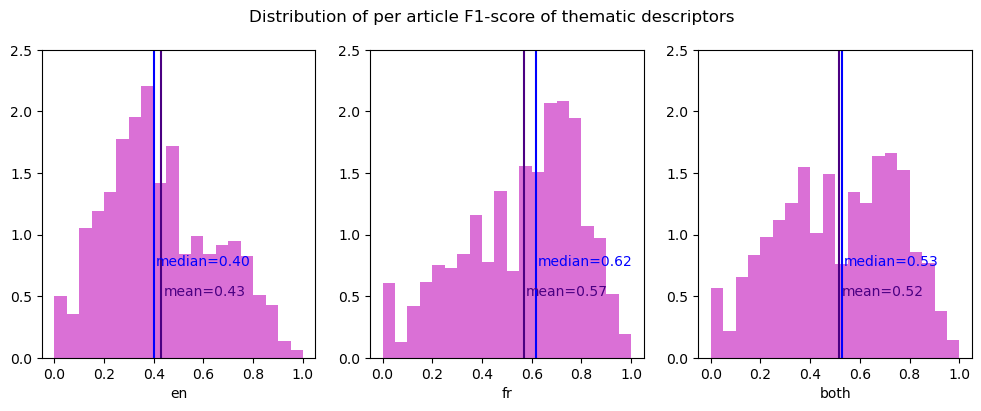

In [207]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per article F1-score of thematic descriptors')

for i, df_f1 in enumerate(df_metrics_articles.values()):
    show_hist(plt, i, df_f1, 'F1', list(df_metrics_articles.keys())[i], hist_color='orchid')
#show_hist(plt, i+1, pd.concat(df_metrics.values() ), 'F1', hist_color='orchid')
    
plt.show()

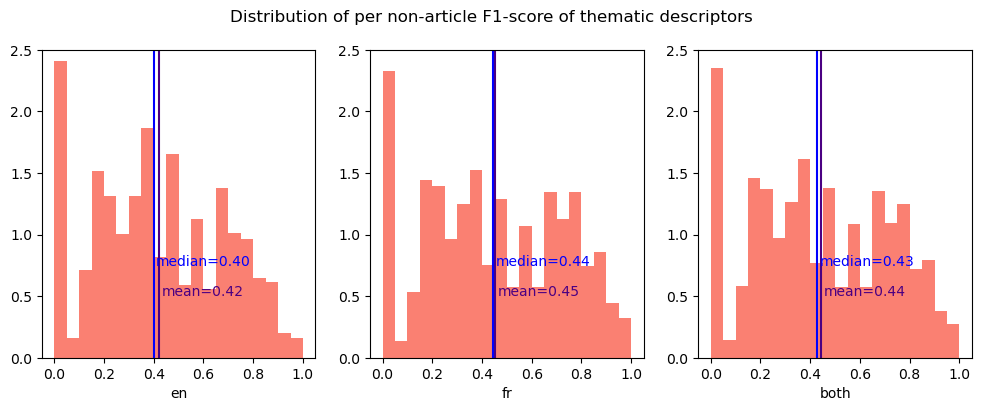

In [208]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per non-article F1-score of thematic descriptors')

for i, df_f1 in enumerate(df_metrics_non_articles.values()):
    show_hist(plt, i, df_f1, 'F1', list(df_metrics_non_articles.keys())[i], hist_color='salmon')
#show_hist(plt, i+1, pd.concat(df_metrics.values() ), 'F1', hist_color='orchid')
    
plt.show()

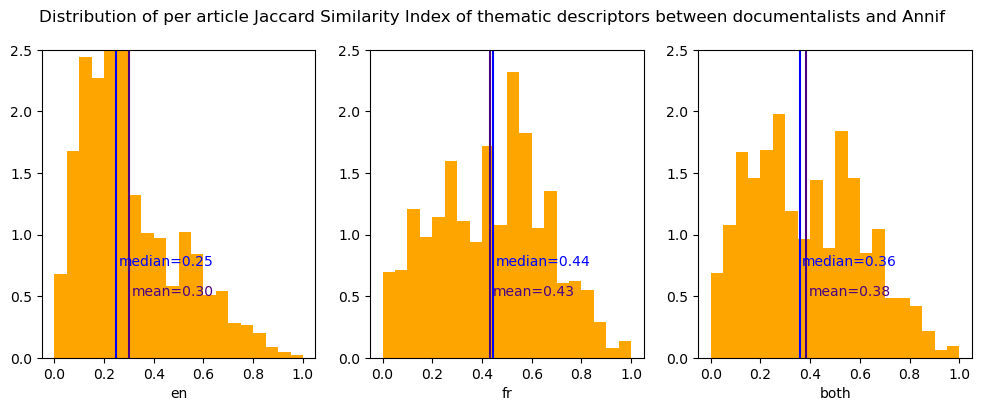

In [209]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per article Jaccard Similarity Index of thematic descriptors between documentalists and Annif')

for i, df_js in enumerate(df_metrics_articles.values()):
    show_hist(plt, i, df_js , column='JaccardIndex', x_label=list(df_metrics_articles.keys())[i], hist_color='orange')

plt.show()

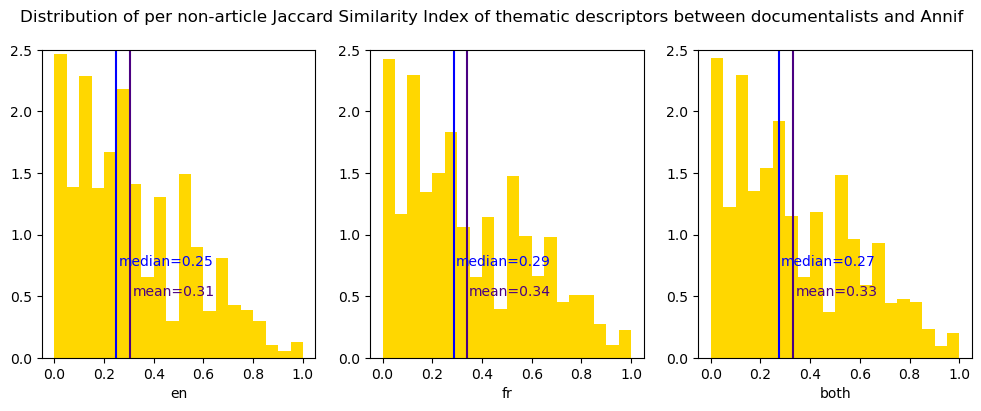

In [210]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Distribution of per non-article Jaccard Similarity Index of thematic descriptors between documentalists and Annif')

for i, df_js in enumerate(df_metrics_non_articles.values()):
    show_hist(plt, i, df_js , column='JaccardIndex',x_label=list(df_metrics_non_articles.keys())[i], hist_color='gold')

plt.show()

#### Calculate statistics @10

In [211]:
pd.options.display.float_format = '{:,.2f}'.format

topK = 10
df_metrics_at10 = {}

for lang in ['en', 'fr']:
    df_metrics_at10[lang] = pd.concat([query_metrics(lang, topK_annif=topK),
                                       query_metrics(lang, topK_annif= topK, articles=False)] )

df_metrics_at10['both'] = pd.concat(df_metrics_at10.values() )
    
df_summary_at10 = summary_dataframe(df_metrics_at10, col_suffix='@10')

df_summary_at10.head()  

en (4934, 11)
en (2781, 11)
fr (8335, 11)
fr (7889, 11)


,Docs,avg. Recall@10,avg. Precision@10,avg. F1 score@10,avg. Jaccard Index@10
language,,,,,
en,7715,0.57,0.42,0.45,0.32
fr,16224,0.64,0.52,0.53,0.41
both,23939,0.62,0.49,0.50,0.38


In [215]:
pd.options.display.float_format = '{:,.2f}'.format

topK = 10
df_metrics_at10 = {}

for lang in ['en', 'fr']:
    df_metrics_at10[lang] = pd.concat([query_metrics(lang, topK_annif=topK),
                                       query_metrics(lang, topK_annif= topK, articles=False)] )

df_metrics_at10['both'] = pd.concat(df_metrics_at10.values() )
    
df_summary_at10 = summary_dataframe(df_metrics_at10, col_suffix='@10')

df_summary_at10.head()  

en (4934, 11)
en (2781, 11)
fr (8335, 11)
fr (7889, 11)


,Docs,avg. Recall@10,avg. Precision@10,avg. F1 score@10,avg. Jaccard Index@10
language,,,,,
en,7715,0.57,0.42,0.45,0.32
fr,16224,0.64,0.52,0.53,0.41
both,23939,0.62,0.49,0.50,0.38


#### Calculate statistics @5

In [216]:
topK = 5
df_metrics_at5 = {}

for lang in ['en', 'fr']:
    df_metrics_at5[lang] = pd.concat([query_metrics(lang, topK_annif=topK),
                                      query_metrics(lang, topK_annif=topK, articles=False)] )

df_metrics_at5['both'] = pd.concat(df_metrics_at5.values() )

df_summary_at5 = summary_dataframe(df_metrics_at5, col_suffix='@5')

pd.options.display.float_format = '{:,.2f}'.format
df_summary_at5.head()  

en (4904, 11)
en (2773, 11)
fr (8326, 11)
fr (7881, 11)


,Docs,avg. Recall@5,avg. Precision@5,avg. F1 score@5,avg. Jaccard Index@5
language,,,,,
en,7677,0.53,0.53,0.48,0.37
fr,16207,0.61,0.62,0.57,0.47
both,23884,0.58,0.59,0.54,0.44


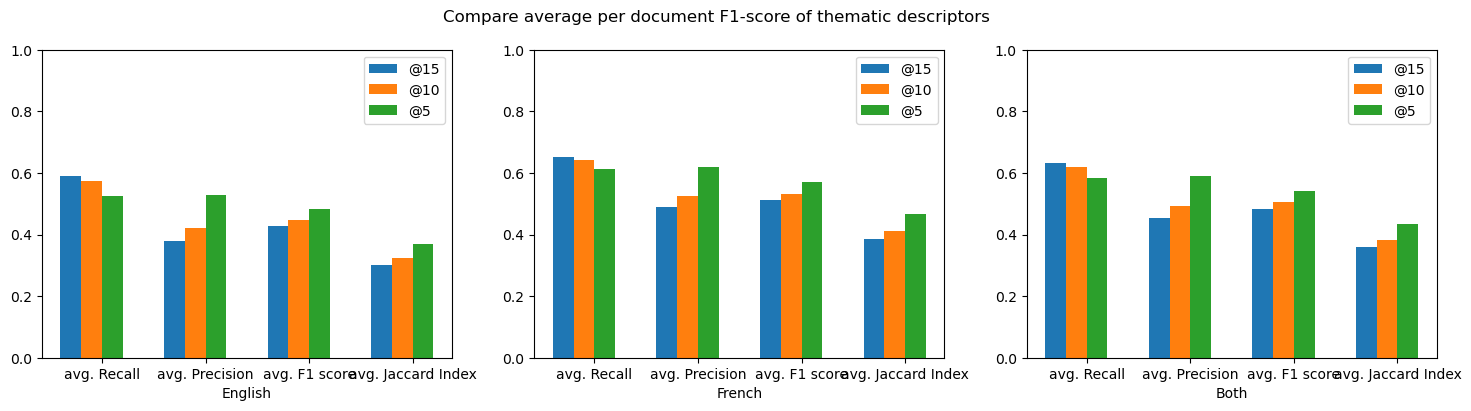

In [217]:
fig = plt.figure(figsize=(18, 4))
fig.suptitle('Compare average per document F1-score of thematic descriptors')

def _compare_metrics_plot(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,1:],      width=width, label='@15')
    plt.bar(x - width/2,   df_summary_at10.iloc[row_num,1:], width=width, label='@10')
    plt.bar(x + width/2,   df_summary_at5.iloc[row_num,1:],  width=width, label='@5')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

_compare_metrics_plot(0, 0)
_compare_metrics_plot(1, 1)
_compare_metrics_plot(2, 2)

plt.show()

In [218]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary.transpose(), df_summary_at10.transpose(), df_summary_at5.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['', '@10', '@5']])) \
     .drop(('Docs', '@10') , axis=0).drop(('Docs', '@5') , axis=0)\
     .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different number of automatically predicted descriptors') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)

CONCLUSION: Taking top K of the Annif descriptors improves the precision but reduces the recall more significantly. 

### Calculate statistic including immediate parents and children for all documents

#### Close relatives (next)


In [219]:
topK = 15
ancestors_depth= 1
descendants_depth=1 

df_metrics_next = {}

for lang in ['en', 'fr']:
    df_metrics_next[lang] = pd.concat([query_metrics(lang, ancestors_depth=1, descendants_depth=0),
                                       query_metrics(lang, ancestors_depth=1, descendants_depth=1, articles=False)])
    
df_metrics_next['both'] = pd.concat(df_metrics_next.values() )

df_summary_next = summary_dataframe(df_metrics_next, col_suffix=' (+next)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_parents.head()   

en (4940, 11)
en (2781, 11)
fr (8335, 11)
fr (7890, 11)


In [ ]:
df_metrics_next['en'].head(5)

#### All relatives (ext)

Match Annif descriptors with manual descriptors, their ancestors and descendants

In [221]:
topK = 15
ancestors_depth= 10
descendants_depth=10 

df_metrics_ext = {}

for lang in ['en' , 'fr']:
    df_metrics_ext[lang] = pd.concat([query_metrics(lang, ancestors_depth=10, descendants_depth=10),
                                                 query_metrics(lang, ancestors_depth=10, descendants_depth=10, articles=False)])

df_metrics_ext['both'] = pd.concat(df_metrics_ext.values() )

df_summary_ext = summary_dataframe(df_metrics_ext, col_suffix=' (+ext)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_ancestors.head()   

en (4940, 11)
en (2781, 11)
fr (8335, 11)
fr (7890, 11)


In [225]:
df_metrics_ext['en'].head(5)

,lang,paperURI,paperID,TP,FN,FP,UNION,Recall,Precision,F1,JaccardIndex
0,eng,http://data-issa.cirad.fr/document/550127,550127,3.00,1.00,8.00,12,0.75,0.27,0.40,0.25
1,eng,http://data-issa.cirad.fr/document/508398,508398,10.00,4.00,5.00,19,0.71,0.67,0.69,0.53
2,eng,http://data-issa.cirad.fr/document/484915,484915,5.00,1.00,6.00,12,0.83,0.45,0.59,0.42
3,eng,http://data-issa.cirad.fr/document/582758,582758,5.00,7.00,3.00,15,0.42,0.62,0.50,0.33
4,eng,http://data-issa.cirad.fr/document/588406,588406,5.00,2.00,10.00,17,0.71,0.33,0.45,0.29


#### Hybrid (hyb)
Match Annif descriptors with manual descriptors, their descendants and immediate parents

In [223]:
topK = 15
ancestors_depth= 1
descendants_depth=10 

df_metrics_hyb = {}

for lang in ['en' , 'fr']:
    df_metrics_hyb[lang] = pd.concat([query_metrics(lang, ancestors_depth=1, descendants_depth=10),
                                                               query_metrics(lang, ancestors_depth=1, descendants_depth=10, articles=False)])

df_metrics_hyb['both'] = pd.concat(df_metrics_hyb.values() )

df_summary_hyb = summary_dataframe(df_metrics_hyb, col_suffix=' (+hyb)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_ancestors.head()  

en (4940, 11)
en (2781, 11)
fr (8335, 11)
fr (7890, 11)


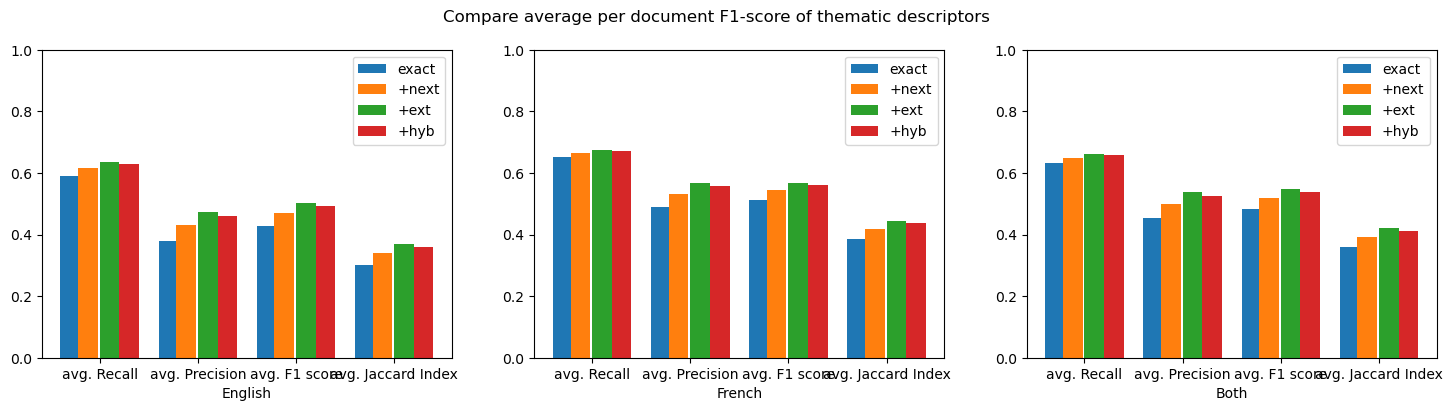

In [226]:
fig = plt.figure(figsize=(18, 4))
fig.suptitle('Compare average per document F1-score of thematic descriptors')

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]+0.2,y[i])

def _compare_metrics_parents(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,1:], width=width, label='exact')
    plt.bar(x - width/5*3,   df_summary_next.iloc[row_num,1:], width=width, label='+next')
    plt.bar(x + width/2,   df_summary_ext.iloc[row_num,1:], width=width, label='+ext')
    plt.bar(x + width/2*3,   df_summary_hyb.iloc[row_num,1:], width=width, label='+hyb')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    
    #addlabels(x - width/2*3,   df_summary_with_descendants_and_parents.iloc[row_num,1:] )

_compare_metrics_parents(0, 0)
_compare_metrics_parents(1, 1)
_compare_metrics_parents(2, 2)

plt.show()

In [227]:
#    [{'selector': 'thead',
#      'props': [('background-color', 'lightblue') ]}]
pd.set_option('display.max_columns', 70)

table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([df_summary.transpose(), 
           df_summary_next.transpose(),
           df_summary_ext.transpose(), 
           df_summary_hyb.transpose()], axis=0) \
     .sort_index()\
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['exact', '+ext', '+hyb', '+next']])) \
      .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different levels of thesaurus hierarchies') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)


OBSERVATIONS: 
- including the thesaurus ancestors along with the descriptors indeed increases the quality metrics.
- the best way to match the manual descriptors and Annif is to look at the full hierarchy of manual descriptors 

### Recalculate statistic for unseen documents

In [228]:
latest_training_paper_id = 575483 #(2.0) 600364 # (1.2) 575483 (2.0)

In [229]:
#print('Full dataset metrics')
#display(df_summary)

print('Latest documents metrics')
df_summary_latest = summary_dataframe(df_metrics_all, from_id = latest_training_paper_id)
#display(df_summary_latest)

print('Latest documents metrics @10')
df_summary_at10_latest = summary_dataframe(df_metrics_at10, from_id = latest_training_paper_id,
                                           col_suffix='@10' )
#display(df_summary_at10_latest) 

print('Latest documents metrics @5')
df_summary_at5_latest = summary_dataframe(df_metrics_at5, from_id = latest_training_paper_id,
                                          col_suffix='@5' )
#display(df_summary_at5_latest) 

print('Latest documents metrics with parents')
df_summary_next_latest = summary_dataframe(df_metrics_next, from_id = latest_training_paper_id,
                                                   col_suffix=' (+parents)' )
#display(df_summary_next_latest) 

print('Latest documents metrics with ancestors')
df_summary_ext_latest = summary_dataframe(df_metrics_ext, from_id = latest_training_paper_id,
                                                     col_suffix=' (+ancestors)' )
#display(df_summary_ext_latest) 

print('Latest documents metrics with all ancestors and 1 parent = hybrid')
df_summary_hyb_latest = summary_dataframe(df_metrics_hyb, from_id = latest_training_paper_id,
                                                     col_suffix=' (+hybrid)' )
#display(df_summary_hyb_latest) 

Latest documents metrics
Latest documents metrics @10
Latest documents metrics @5
Latest documents metrics with parents
Latest documents metrics with ancestors
Latest documents metrics with all ancestors and 1 parent = hybrid


In [230]:
table_style = [{"selector": "", "props": [("border", "3px solid orchid !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary.transpose(), df_summary_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['full', 'latest']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for full set and the latest documents only') \
     .highlight_max(subset='avg. F1 score', color='orchid', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='orchid', axis=1) \
     .highlight_max(subset='avg. Precision', color='orchid', axis=1) \
     .highlight_max(subset='avg. Recall', color='orchid', axis=1)

In [231]:
table_style = [{"selector": "", "props": [("border", "3px solid lightpink !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary_latest.transpose(), df_summary_at10_latest.transpose(), df_summary_at5_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['', '@10', '@5']])) \
     .drop(('Docs', '@10') , axis=0).drop(('Docs', '@5') , axis=0)\
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different number of automatically predicted descriptors for the latest documents') \
     .highlight_max(subset='avg. F1 score', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightpink', axis=1)

In [233]:
#    [{'selector': 'thead',
#      'props': [('background-color', 'lightblue') ]}]
table_style = [{"selector": "", "props": [("border", "3px solid lightpink !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

display_html(pd.concat([df_summary_latest.transpose(),
                        df_summary_next_latest.transpose(),
                        df_summary_ext_latest.transpose(),
                        df_summary_hyb_latest.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary_latest.columns.sort_values(), ['exact', '+ext', '+hyb', '+next']])) \
     .drop(('Docs', '+ext') , axis=0).drop(('Docs', '+hyb') , axis=0).drop(('Docs', '+next') , axis=0)\
     .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different levels of thesaurus hierarchies') \
     .highlight_max(subset='avg. F1 score', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightpink', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightpink', axis=1))


Compare metrics for different levels of thesaurus hierarchies 
 
 
 
 Docs 
 avg. F1 score 
 avg. Jaccard Index 
 avg. Precision 
 avg. Recall 
 
 
   
 exact 
 exact 
 +ext 
 +hyb 
 +next 
 exact 
 +ext 
 +hyb 
 +next 
 exact 
 +ext 
 +hyb 
 +next 
 exact 
 +ext 
 +hyb 
 +next 
 
 
 language 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 en 
 3861 
 0.31 
 0.40 
 0.39 
 0.36 
 0.19 
 0.26 
 0.25 
 0.23 
 0.29 
 0.39 
 0.38 
 0.34 
 0.44 
 0.50 
 0.49 
 0.47 
 
 
 fr 
 2215 
 0.29 
 0.36 
 0.35 
 0.33 
 0.18 
 0.24 
 0.23 
 0.22 
 0.35 
 0.45 
 0.43 
 0.41 
 0.34 
 0.39 
 0.38 
 0.37 
 
 
 both 
 6076 
 0.30 
 0.38 
 0.37 
 0.35 
 0.19 
 0.25 
 0.24 
 0.22 
 0.31 
 0.41 
 0.40 
 0.37 
 0.40 
 0.46 
 0.45 
 0.43

OBSERVATIONS: 
- including the thesaurus ancestors along with the descriptors increases the quality metrics on unseen by training documents as well
- the best way to match the manual descriptors and Annif is to look at the full hierarchy of manual descriptors

## Per descriptor statistics 

In [234]:
ns=issa_instances[instance]['namespace']

query_descriptors_count_templ = f'''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos:   <http://www.w3.org/2008/05/skos-xl>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <{ns}>

SELECT ?uri ?descriptorLabel ?indexer
      (count(distinct ?paper) as ?cnt)
      (max(?gn) as ?hasGN)
      (max(?geo_descriptor) as ?isGeo)
WHERE {{
	?descriptor a issa:ThematicDescriptorAnnotation;
    oa:hasBody ?uri;
    oa:hasTarget ?paper;
    prov:wasAttributedTo ?indexer.
    FILTER (?indexer = %s) # issa:Documentalist | issa:AnnifSubjectIndexer
  
  OPTIONAL {{
        ?uri skosxl:prefLabel/skosxl:literalForm ?descriptorLabel.
        FILTER langMatches(lang(?descriptorLabel), "en" )
        
        BIND ( EXISTS {{?gnUri gn:officialName|gn:alternateName|gn:name|gn:shortName ?descriptorLabel }} as ?gn)
  }}
  
  OPTIONAL {{
        ?uri <http://aims.fao.org/aos/agrontology#isPartOfSubvocabulary> ?subVocabulary .
        BIND ( REGEX(?subVocabulary, "^Geographical", "i") as ?geo_descriptor)
  }}
  
}}
GROUP BY ?uri ?descriptorLabel ?indexer
ORDER BY desc(?cnt)
'''

In [235]:
indexers = {'human' : 'issa:Documentalist',
            'annif': 'issa:AnnifSubjectIndexer'}
df_descr_count={}

for key, value in indexers.items():
    print(key, end=' ')
    df_descr_count[key] = sparql_service_to_dataframe(issa_agritrop_endpoint, query_descriptors_count_templ %  indexers[key])
    df_descr_count[key].dropna(inplace=True)
    df_descr_count[key] = df_descr_count[key].astype({'cnt': 'int', 'hasGN': 'int', 'isGeo': 'int'})
    print(indexers[key] , df_descr_count[key].shape)


human issa:Documentalist (8146, 6)
annif issa:AnnifSubjectIndexer (10880, 6)


In [236]:
cols = df_descr_count.keys()

df_descr_summary=pd.DataFrame(columns=cols)

for indexer in df_descr_count:
    df_descr_summary.loc['unique count', indexer] = df_descr_count[indexer].cnt.shape[0]
    df_descr_summary.loc['total count', indexer] =  df_descr_count[indexer].cnt.sum()
    df_descr_summary.loc['geo count', indexer] =  df_descr_count[indexer].isGeo.sum()
    df_descr_summary.loc['GN count', indexer] =  df_descr_count[indexer].hasGN.sum()


    df_descr_summary.loc['mean frequency', indexer] = df_descr_count[indexer].cnt.mean()
    df_descr_summary.loc['frequency std', indexer] =  df_descr_count[indexer].cnt.std()

    df_descr_summary.loc['% of low frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt < 2].shape[0] / df_descr_count[indexer].shape[0]
    df_descr_summary.loc['% of high frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt > 500 ].shape[0] / df_descr_count[indexer].shape[0]


table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_descr_summary.transpose() \
                .style.set_table_styles(table_style) \
                .format(precision=2) 


,unique count,total count,geo count,GN count,mean frequency,frequency std,% of low frequency,% of high frequency
human,8146,193389,389,313,23.74,83.75,0.28,0.00
annif,10880,348262,474,394,32.01,174.16,0.35,0.01


In [237]:
df_descr_count[key].head()

,uri,descriptorLabel,indexer,cnt,hasGN,isGeo
0,http://aims.fao.org/aos/agrovoc/c_3081,France,http://data-issa.cirad.fr/AnnifSubjectIndexer,12515,1,1
1,http://aims.fao.org/aos/agrovoc/c_6513,research,http://data-issa.cirad.fr/AnnifSubjectIndexer,2156,0,0
2,http://aims.fao.org/aos/agrovoc/c_1229,Cameroon,http://data-issa.cirad.fr/AnnifSubjectIndexer,2129,1,1
3,http://aims.fao.org/aos/agrovoc/c_6543,Réunion,http://data-issa.cirad.fr/AnnifSubjectIndexer,2001,1,1
4,http://aims.fao.org/aos/agrovoc/c_165,Africa,http://data-issa.cirad.fr/AnnifSubjectIndexer,1997,1,1


#### Human indexing

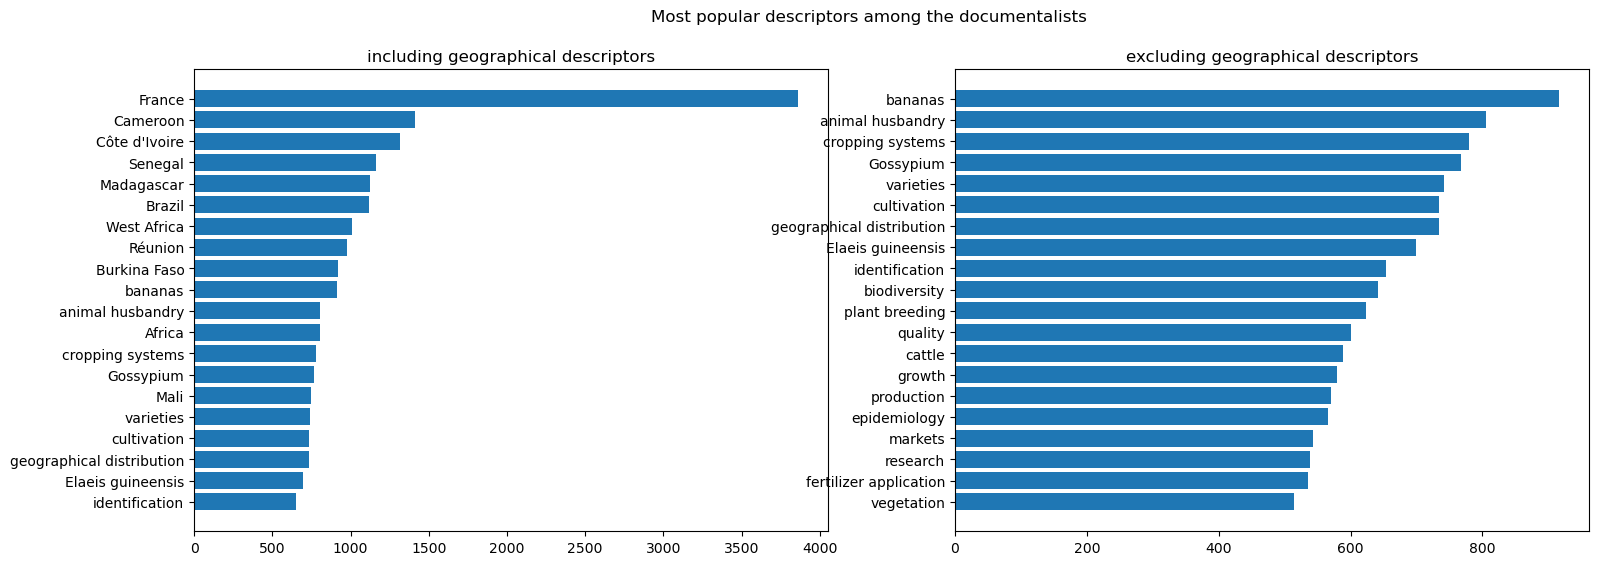

In [238]:
top_20 = df_descr_count['human'].sort_values(by='cnt', ascending=False)[:20]

top_20_non_geo = df_descr_count['human'][df_descr_count['human'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors among the documentalists')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt ) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(top_20_non_geo.descriptorLabel, width=top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Machine indexing

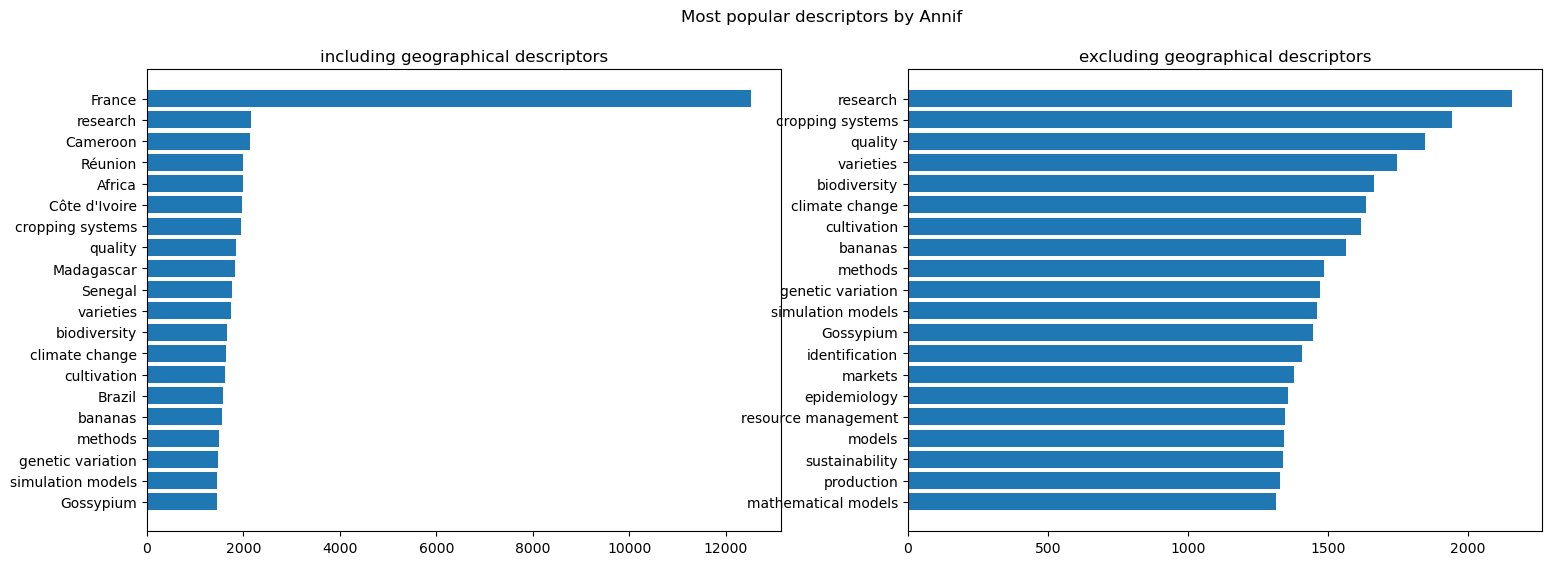

In [239]:
top_20 = df_descr_count['annif'].sort_values(by='cnt', ascending=False)[:20]

df_descr_count_a_top_20_non_geo = df_descr_count['annif'][df_descr_count['annif'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors by Annif')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(df_descr_count_a_top_20_non_geo.descriptorLabel, width=df_descr_count_a_top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Compare human and automatic indexing

In [240]:
pd.options.display.max_colwidth = None
df_merged = df_descr_count['human'].merge(df_descr_count['annif'],
                                            on='uri',
                                            how='outer',
                                            suffixes=['_human', '_annif'] )

#df_merged.describe().transpose()

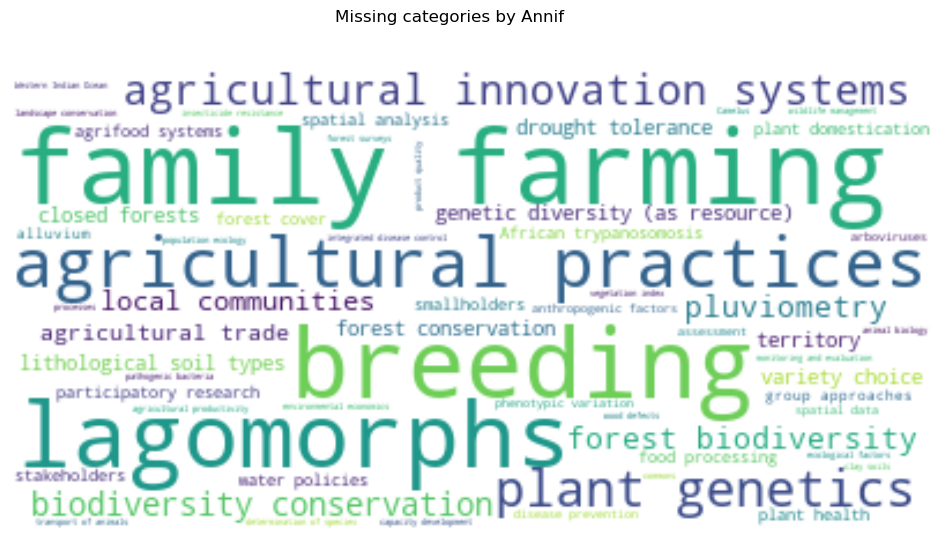

In [241]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

missing_categories = df_merged[df_merged.descriptorLabel_annif.isna()]
missing_categories.shape

freq = dict(zip(missing_categories.descriptorLabel_human, missing_categories.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Missing categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

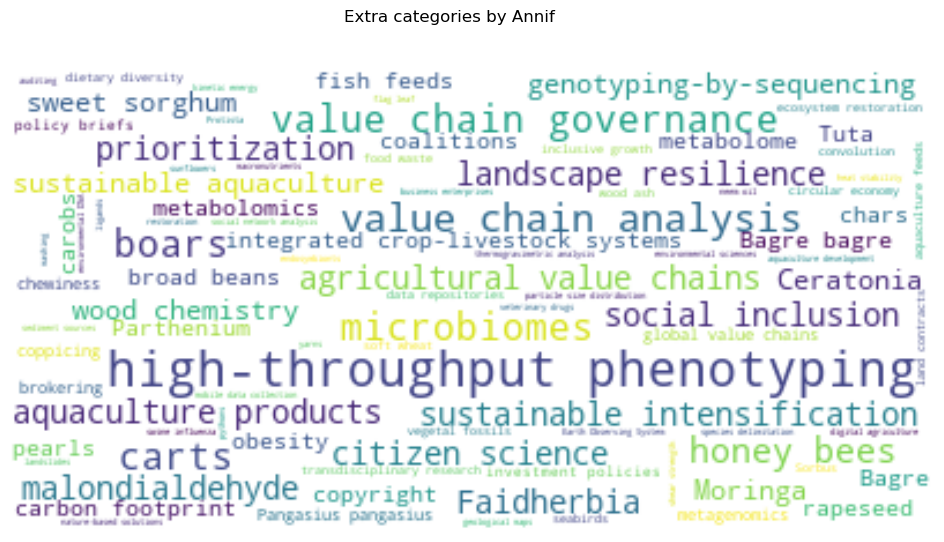

In [242]:
extra_categories = df_merged[df_merged.descriptorLabel_human.isna()]
extra_categories.shape

freq = dict(zip(extra_categories.descriptorLabel_annif, extra_categories.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

CONCLUSION: Annif had missed more general descriptors such as *family farming* or *agricultural practicies* and added more precise descriptors like *sustainable agriculture* or *high-trouput phenotyping*.  

#### Compare Geographical descriptors

(47, 11)


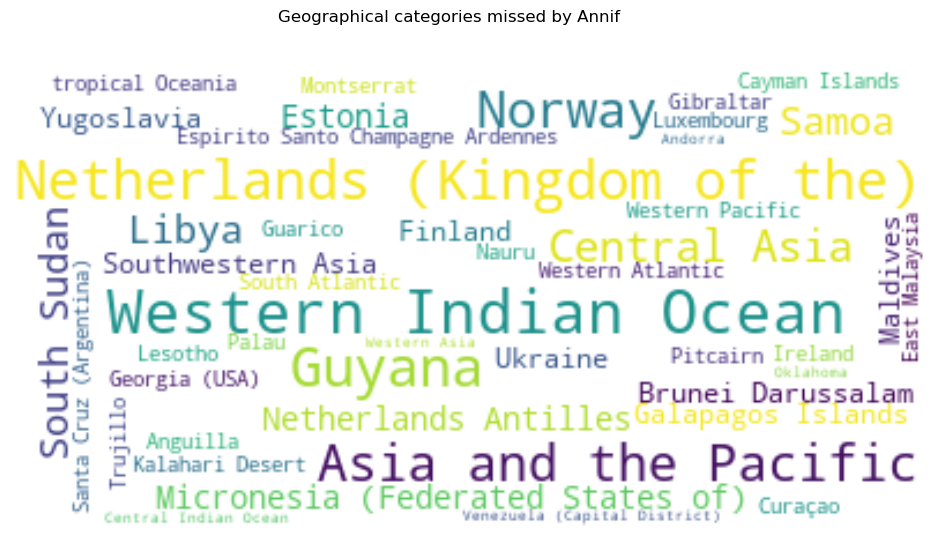

In [243]:
missing_categories_geo = missing_categories[missing_categories.isGeo_human == 1]
print(missing_categories_geo.shape)

freq = dict(zip(missing_categories_geo.descriptorLabel_human, missing_categories_geo.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Geographical categories missed by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(132, 11)


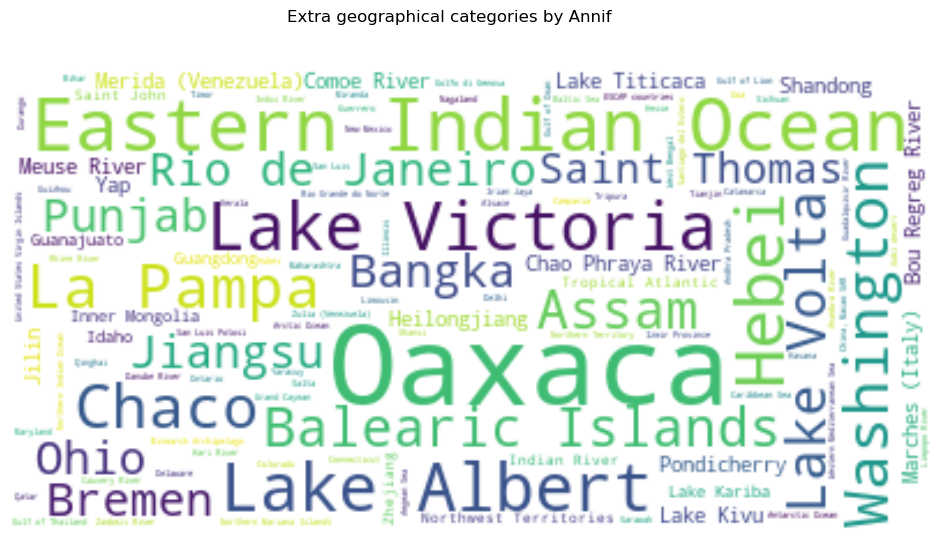

In [244]:
extra_categories_geo = extra_categories[extra_categories.isGeo_annif == 1 ]
print(extra_categories_geo.shape)

freq = dict(zip(extra_categories_geo.descriptorLabel_annif, extra_categories_geo.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra geographical categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

OBSERVATIONS: It seems that Annif had missed some multi-word geographical locations. Can't say much about the extra geographical categories except that they are not occured more than twice.